In [1]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Spheres I

In [84]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
nn = KNeighborsClassifier(n_neighbors=1)
svm = SVC(C=1e5, kernel='linear')

In [85]:
P = 100
N = 500
m = 10
dx0 = 1

def sphere_experiment(m,N):
    U = np.random.randn(2*N+1,2*N+1)
#     U,_ = np.linalg.qr(U)
    Ua = U[:N]
    Ub = U[N:2*N]
#     mu = U[-1]

    mu = np.random.randn(N)
    mu /= np.linalg.norm(mu)

    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatrain = mu*dx0/2 + s

    s = np.random.randn(P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatest = mu*dx0/2 + s

    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtrain = -mu*dx0/2 + s

    w = Xatrain.mean(0) - Xbtrain.mean(0)
    mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
    h = Xatest@w - w@mu
    proto_err = (h<0).mean()

    ytrain = np.concatenate([np.ones(m),-np.ones(m)])
    Xtrain = np.vstack([Xatrain,Xbtrain])
#     nn.fit(Xtrain,ytrain)
#     yhat = nn.predict(Xatest)
#     NN_err = (yhat!=1).mean()
    
    svm.fit(Xtrain,ytrain)
    yhat = svm.predict(Xatest)
    svm_err = (yhat!=1).mean()
    
    return proto_err, svm_err

In [117]:
P = 100
N = 100
m = 20
dx0 = 1

U = np.random.randn(2*N+1,2*N+1)
#     U,_ = np.linalg.qr(U)
Ua = U[:N]
Ub = U[N:2*N]
#     mu = U[-1]

mu = np.random.randn(N)
mu /= np.linalg.norm(mu)

s = np.random.randn(m,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xatrain = mu*dx0/2 + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xatest = mu*dx0/2 + s

s = np.random.randn(m,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xbtrain = -mu*dx0/2 + s

w = Xatrain.mean(0) - Xbtrain.mean(0)
mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
h = Xatest@w - w@mu
proto_err = (h<0).mean()

ytrain = np.concatenate([np.ones(m),-np.ones(m)])
Xtrain = np.vstack([Xatrain,Xbtrain])

svm.fit(Xtrain,ytrain)

SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [118]:
w = Xatrain.mean(0) - Xbtrain.mean(0)
mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
h = Xatest@w - w@mu
proto_err = (h<0).mean()
print(proto_err)

0.0


In [119]:
yhat = svm.predict(Xatest)
svm_err = (yhat!=1).mean()
print(svm_err)

0.0


In [86]:
proto_errs = []
NN_errs = []
svm_errs = []

Ns = np.arange(1,10)
ms = np.arange(1,20,dtype='int')
n_avg = 100
for m in tqdm(ms):
    for N in tqdm(Ns,leave=False):
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
#             svm_errs.append(svm_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
# svm_errs = np.stack(svm_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

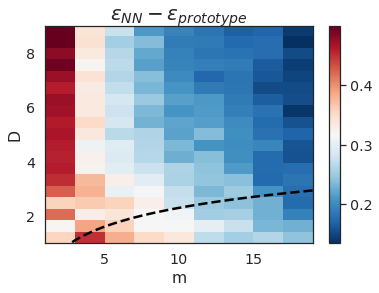

In [91]:
with sns.axes_style('white'):
    diff = NN_errs
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto')
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

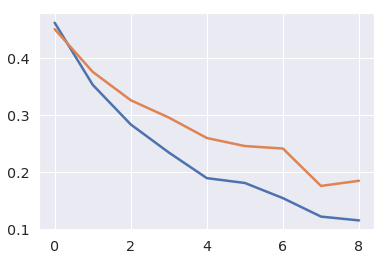

In [92]:
plt.plot(proto_errs[5])
plt.plot(NN_errs[5])

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

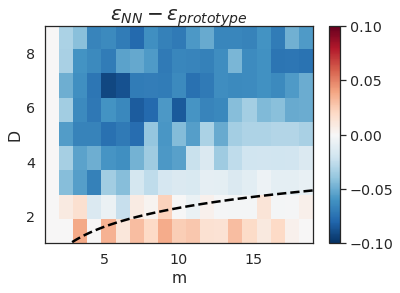

In [93]:
with sns.axes_style('white'):
    diff = (proto_errs - NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmax=0.1, vmin=-0.1)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

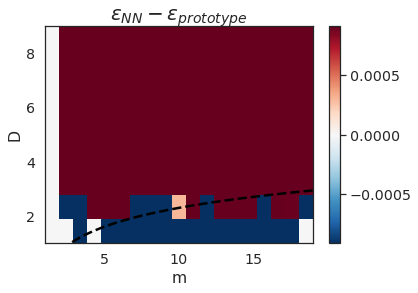

In [90]:
with sns.axes_style('white'):
    diff = -(proto_errs - NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmin=-vmax/100,vmax=vmax/100)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

In [85]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,11)
ms = np.logspace(2,10,10,base=2,dtype='int')
n_avg = 10
for m in tqdm(ms):
    for N in Ns:
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

# Manifolds

In [2]:
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50'
manifolds_load = np.load(os.path.join(emb_path,'manifolds.npy'),allow_pickle=True)

In [3]:
P = 500
manifolds = []
for manifold in manifolds_load:
    manifolds.append(manifold[:P])
manifolds = np.stack(manifolds)

In [4]:
centers = np.load(os.path.join(emb_path, 'centers.npy'))

In [5]:
a = 0
b = 1
Xa = manifolds[a]
Xb = manifolds[b]
x0a = centers[a]
x0b = centers[b]

Ua,Sa,Va = np.linalg.svd(Xa - x0a, full_matrices=False)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b, full_matrices=False)

In [8]:
k = 500
Xak = Ua[:,:k]*Sa[:k]@Va[:k]
Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]

In [7]:
from sklearn.svm import SVC
svm = SVC(C=1e5,kernel='linear')

In [ ]:
n_avg = 10
ks = np.arange(1,10,2)
ms = np.arange(1,10)
svm_errs = []
proto_errs = []
for k in tqdm(ks):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    for m in tqdm(ms,leave=False):
        for _ in range(n_avg):
            ia = np.random.permutation(P)
            ib = np.random.permutation(P)
            Xatrain, Xatest = np.split(Xak[ia],(m,))
            Xbtrain, Xbtest = np.split(Xbk[ia],(m,))

            w = Xatrain.mean(0) - Xbtrain.mean(0)
            mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
            h = Xatest@w - w@mu
            proto_err = (h<0).mean()
            proto_errs.append(proto_err)

            ytrain = np.concatenate([np.ones(m),-np.ones(m)])
            Xtrain = np.vstack([Xatrain,Xbtrain])

            svm.fit(Xtrain,ytrain)
            yhat = svm.predict(Xatest)
            svm_err = (yhat!=1).mean()
            svm_errs.append(svm_err)
svm_errs = np.stack(svm_errs).reshape(len(ks),len(ms),n_avg)
proto_errs = np.stack(proto_errs).reshape(len(ks),len(ms),n_avg)

In [11]:
svm_errs = np.stack(svm_errs).reshape(len(ks),len(ms))

In [12]:
proto_errs = np.stack(proto_errs).reshape(len(ks),len(ms))

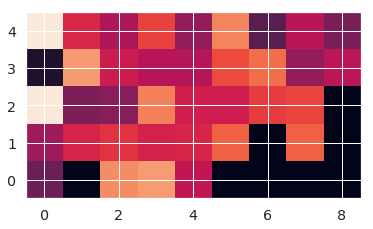

In [15]:
plt.imshow(svm_errs, origin='lower')

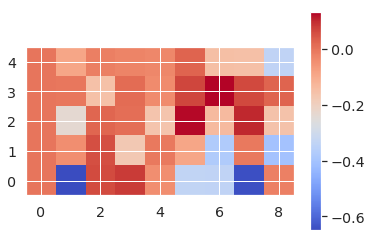

In [20]:
plt.imshow(svm_errs-proto_errs, origin='lower', cmap='coolwarm')
plt.colorbar();

In [467]:
Rs = np.load(os.path.join(emb_path,'Rs.npy'))

In [430]:
from scipy.spatial.distance import cdist

In [708]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)

In [721]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

navg = 100
errs = []
err_proto = []
ms = np.arange(1,100,5)
for m in tqdm(ms):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    for _ in range(navg):
        idxs_a = np.random.permutation(K)
        idxs_b = np.random.permutation(K)

        xatrain,xatest = np.split(Xa[idxs_a],(m,))
        xbtrain,xbtest = np.split(Xb[idxs_b],(m,))

        xtrain = np.vstack([xatrain,xbtrain])
        y = np.concatenate([np.ones(m),-np.ones(m)])

        nn.fit(xtrain,y)
        yahat = nn.predict(xatest)
        ybhat = nn.predict(xbtest)

        err = ((yahat!=1).mean() + (ybhat!=-1).mean())/2
        errs.append(err)
        
        w = (xatrain-xbtrain).mean(0)
        mu = (xatrain+xbtrain).mean(0)/2
        ha = xatest@w - w@mu
        hb = xbtest@w - w@mu
        err_a = (ha<0).mean()
        err_b = (hb>0).mean()
        err_proto.append((err_a+err_b)/2)
errs = np.stack(errs).reshape(len(ms),navg).mean(-1)
err_proto = np.stack(err_proto).reshape(len(ms),navg).mean(-1)

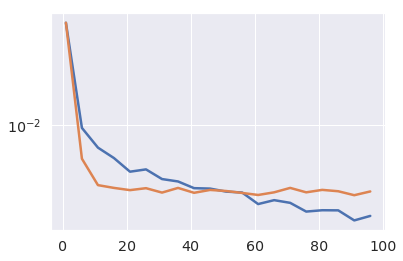

In [722]:
plt.plot(ms, errs)
plt.plot(ms, err_proto)
plt.yscale('log')

In [544]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [553]:
a = 10
b = 12
Xa = manifolds[a][:500]
Xb = manifolds[b][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [472]:
K = len(Xa)
ks = np.logspace(1,8,20,base=2,dtype='int')

dds = []
for k in tqdm(ks):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    daa = cdist(Xak,Xak) + np.eye(K)*1e6
    dab = cdist(Xak,Xbk) + np.eye(K)*1e6
    
    dd = (np.min(dab,axis=-1) - np.min(daa,axis=-1)) / np.min(daa,axis=-1)
    dds.append(np.mean(dd))

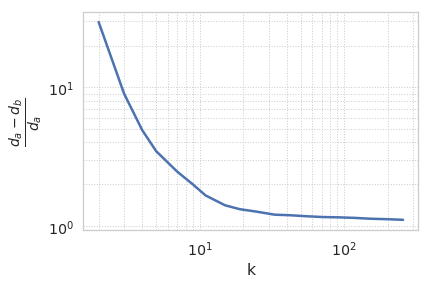

In [473]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

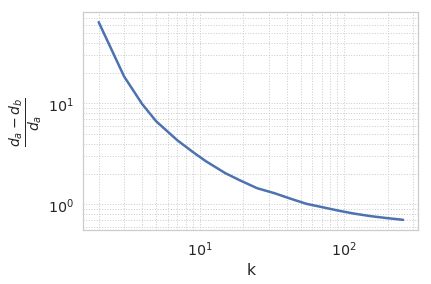

In [389]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds)
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

In [395]:
K = len(Xa)
ks = np.logspace(1,8,20,base=2,dtype='int')

ms = [1,2,5,10]
dds = []
for m in tqdm(ms):
    for k in ks:
        Xak = Ua[:,:k]*Sa[:k]@Va[:k] + x0a
        Xbk = Ub[:,:k]*Sb[:k]@Vb[:k] + x0b

        Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
        daa = cdist(Xak[K//2:],Xam)

        Xbm = Xbk[:K//2].reshape(m,-1,2048).mean(0)
        dab = cdist(Xak[K//2:],Xbm)

        dd =  (np.min(dab,axis=0) - np.min(daa,axis=0)) / np.min(daa,axis=0)
        dds.append(np.min(dd))
dds = np.stack(dds).reshape(len(ms),len(ks))

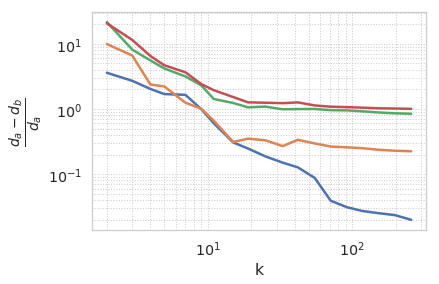

In [396]:
with sns.axes_style('whitegrid'):
    plt.plot(ks,dds.T)

    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True, which="both",ls = ':')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{d_a-d_b}{d_a}$',fontsize=20)

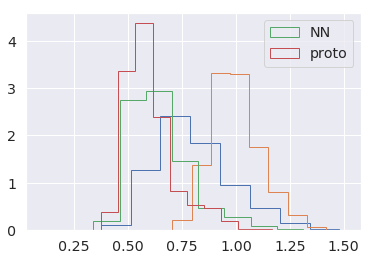

In [765]:
k = 500
m = 10
Xak = Ua[:,:k]*Sa[:k]@Va[:k]
Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
Xak += x0a
Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
Xbk += x0b

daa = cdist(Xak[K//2:],Xak[:K//2])
dab = cdist(Xak,Xbm)

# NN
daNN = daa.reshape(m,-1).min(0)

plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True, label='NN')

Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
daproto = cdist(Xak[K//2:],Xam)
plt.hist(daproto.ravel()/dab.mean(),histtype='step', density=True, label='proto');
plt.legend();

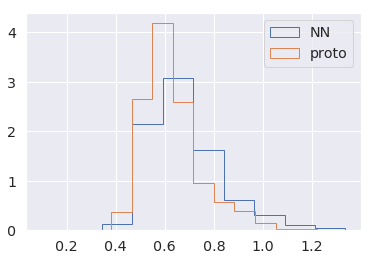

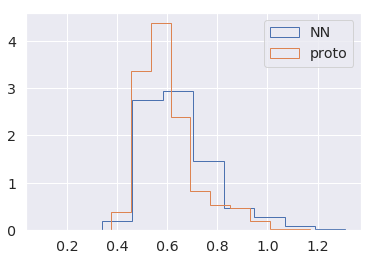

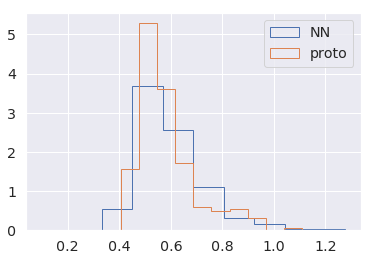

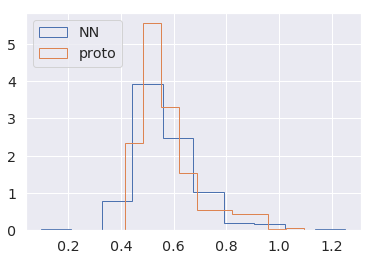

In [762]:
k = 500
ms = [5,10,50,125]
for m in ms:
    plt.figure()
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    daa = cdist(Xak[K//2:],Xak[:K//2])
    dab = cdist(Xak,Xbm)

    # NN
    daNN = daa.reshape(m,-1).min(0)

    # plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
    # plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)
    plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True, label='NN')

    Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
    daproto = cdist(Xak[K//2:],Xam)
    plt.hist(daproto.ravel()/dab.mean(),histtype='step', density=True, label='proto');
    plt.legend();

(array([2.31232336e-04, 4.62464671e-04, 1.08563582e-01, 1.26969675e+00,
        2.40678177e+00, 1.83482858e+00, 9.64470072e-01, 4.75066834e-01,
        1.46254452e-01, 1.96547485e-02]),
 array([0.09618   , 0.23456895, 0.3729579 , 0.51134685, 0.6497358 ,
        0.78812475, 0.9265137 , 1.06490264, 1.20329159, 1.34168054,
        1.48006949]),
 <a list of 1 Patch objects>)

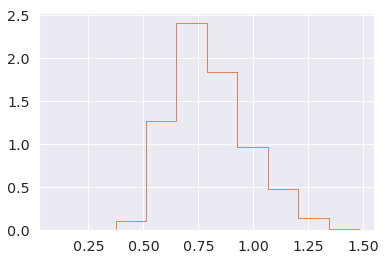

In [741]:
plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(daNN.ravel()/dab.mean(),histtype='step', density=True)

(array([7.03204976e-05, 3.51602488e-05, 7.38365225e-03, 1.16696866e-01,
        1.67890188e-01, 8.86741475e-02, 3.31912749e-02, 1.70878809e-02,
        6.15304354e-03, 2.32057642e-03]),
 array([ 1.76630878,  4.04160553,  6.31690229,  8.59219904, 10.86749579,
        13.14279255, 15.4180893 , 17.69338606, 19.96868281, 22.24397956,
        24.51927632]),
 <a list of 10 Patch objects>)

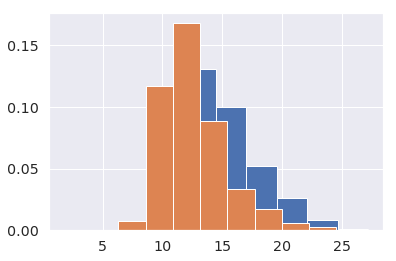

In [735]:
plt.hist(daa.ravel(),density=True)
plt.hist(daNN.ravel(),density=True)

(0, 2.0)

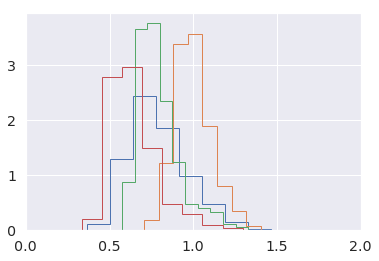

In [556]:
k = 500
m = 1
Xak = Ua[:,:k]*Sa[:k]@Va[:k]
Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
Xak += x0a
Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
Xbk += x0b

Xam = Xak[:K//2].reshape(m,-1,2048).mean(0)
daa = cdist(Xak[K//2:],Xam)

Xbm = Xbk[:K//2].reshape(m,-1,2048).mean(0)
dab = cdist(Xak[K//2:],Xbm)

plt.hist(daa.ravel()/dab.mean(),histtype='step', density=True)
plt.hist(dab.ravel()/dab.mean(),histtype='step', density=True)

m = 10
daamean = daa.reshape(m,-1).mean(0) /dab.mean()
plt.hist(daamean,histtype='step', density=True)

daamean = daa.reshape(m,-1).min(0) /dab.mean()
plt.hist(daamean,histtype='step',density=True)
plt.xlim([0,2.])


(0, 2.0)

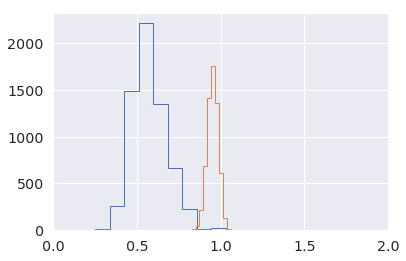

In [529]:
m = 10
daamean = daa.reshape(m,-1).min(0) /dab.mean()
dabmean = dab.reshape(m,-1).min(0) /dab.mean()

plt.hist(daamean,histtype='step')
plt.hist(dabmean,histtype='step')
plt.xlim([0,2.])

In [544]:
Xa = manifolds[0][:500]
Xb = manifolds[1][:500]

x0a = Xa.mean(0)
Ua,Sa,Va = np.linalg.svd(Xa - x0a)

x0b = Xb.mean(0)
Ub,Sb,Vb = np.linalg.svd(Xb - x0b)

In [545]:
navg = 100
errs = []
err_proto = []
for k in tqdm(ks):
    Xak = Ua[:,:k]*Sa[:k]@Va[:k]
    Xak *= (Rs[a]**2).sum() / (Rs[a,:k]**2).sum()
    Xak += x0a
    Xbk = Ub[:,:k]*Sb[:k]@Vb[:k]
    Xbk *= (Rs[b]**2).sum() / (Rs[b,:k]**2).sum()
    Xbk += x0b

    for _ in range(navg):
        idxs_a = np.random.permutation(K)
        idxs_b = np.random.permutation(K)

        xatrain,xatest = np.split(Xak[idxs_a],(m,))
        xbtrain,xbtest = np.split(Xbk[idxs_b],(m,))

        xtrain = np.vstack([xatrain,xbtrain])
        y = np.concatenate([np.ones(m),-np.ones(m)])

        nn.fit(xtrain,y)
        yahat = nn.predict(xatest)
        ybhat = nn.predict(xbtest)

        err = ((yahat!=1).mean() + (ybhat!=-1).mean())/2
        errs.append(err)
        
        w = (xatrain-xbtrain).mean(0)
        mu = (xatrain+xbtrain).mean(0)/2
        h = xatest@w - w@mu
        err = (h<0).mean()
        err_proto.append(err)
errs = np.stack(errs).reshape(len(ks),navg).mean(-1)
err_proto = np.stack(err_proto).reshape(len(ks),navg).mean(-1)

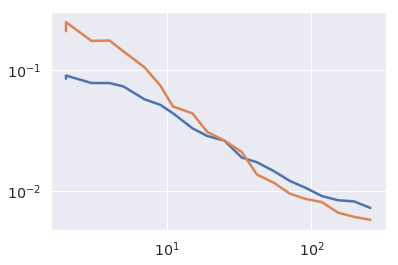

In [546]:
plt.plot(ks, errs)
plt.plot(ks, err_proto)
plt.xscale('log')
plt.yscale('log')

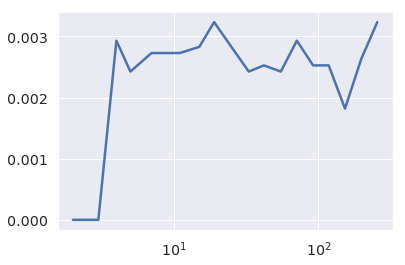

In [462]:
plt.plot(ks, errs)
plt.xscale('log')

In [507]:
N = 5000
X = np.random.randn(m,N)
Y = np.random.randn(N)
X0 = X.mean(0)

In [515]:
((X-Y)**2).sum(-1)

array([10301.28012082,  9973.16104665, 10218.03955633,  9994.68989619,
       10211.39306289, 10293.83136541, 10253.97427266, 10339.23245439,
       10077.44627971, 10102.74922224])

In [516]:
np.sqrt(((X-Y)**2).sum(-1)).mean()

100.87715037368135

In [511]:
np.sqrt(((X0-Y)**2).sum(-1))

75.40627940827969

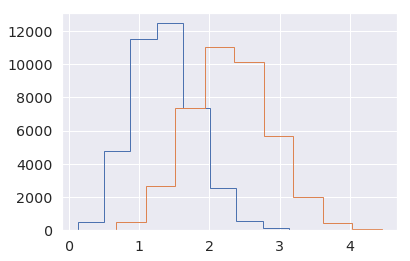

In [558]:
N = 5
U = np.random.randn(N,N)
U,_ = np.linalg.qr(U)

x0 = U[0] 

sa = np.random.randn(P,N) / np.sqrt(N)
sb = np.random.randn(P,N) / np.sqrt(N)
sigma = np.random.randn(P,N) / np.sqrt(N)

xa = x0 + sa
xia = x0 + sigma
xb = -x0 + sb

daa = cdist(xa,xia)
dab = cdist(xa,xb)

mask = np.eye(P,dtype='bool')
plt.hist(cdist(xa,xia)[~mask],histtype='step')
plt.hist(cdist(xa,xb)[~mask],histtype='step');

In [569]:
U = np.random.randn(m+1,N)
U,_ = np.linalg.qr(U.T)

In [593]:
N = 2000
U = np.random.randn(m+1,N)
U,_ = np.linalg.qr(U.T)
U = U.T
# X = np.random.randn(m,N)
# Y = np.random.randn(N)
X = U[:-1]
Y = U[-1]
print(((Y - X.mean(0))**2).sum())
print(((Y - X)**2).sum(-1).mean()*(m-1)/m)

1.1
1.8


In [190]:
P = 2000
N = 500
m = 10
s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
mu = np.random.randn(N) / np.sqrt(N)
X = mu + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X2 = mu + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Y = -mu + s

daa = cdist(X,X2)
dab = cdist(X,Y)

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X = mu + s
X = X.reshape(m,-1,N).mean(0)
daproto = cdist(X,X2)

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
X = mu + s
damin = cdist(X,X2).reshape(m,-1,P).min(0)

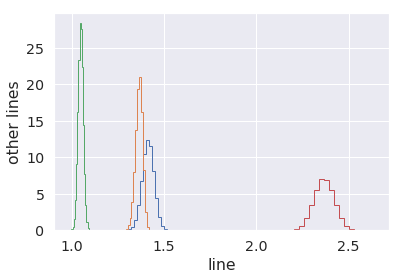

In [192]:
mask = np.eye(P,dtype='bool')
plt.hist(daa.ravel(), bins=20, histtype='step', density=True)
plt.hist(damin.ravel(), bins=20, histtype='step', density=True)
plt.hist(daproto.ravel(), bins=20, histtype='step', density=True)
plt.hist(dab.ravel(), bins=20, histtype='step', density=True)
# plt.axvline(np.sqrt(2))
# plt.axvline(np.sqrt(2)+1);
plt.xlabel('line')
plt.ylabel('other lines');

(array([2.36123696e-04, 2.82174340e-03, 1.22810413e-02, 3.35660923e-02,
        7.21194823e-02, 1.32211006e-01, 2.17463401e-01, 3.21833989e-01,
        4.36768828e-01, 5.43829400e-01, 6.14712168e-01, 6.32418836e-01,
        6.01275294e-01, 5.34580134e-01, 4.28268375e-01, 3.09695143e-01,
        1.94470693e-01, 9.61375672e-02, 2.97724585e-02, 3.74145172e-03]),
 array([0.64598835, 0.8376252 , 1.02926204, 1.22089889, 1.41253573,
        1.60417258, 1.79580942, 1.98744627, 2.17908311, 2.37071995,
        2.5623568 , 2.75399364, 2.94563049, 3.13726733, 3.32890418,
        3.52054102, 3.71217786, 3.90381471, 4.09545155, 4.2870884 ,
        4.47872524]),
 <a list of 1 Patch objects>)

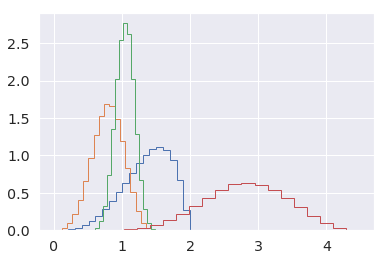

In [701]:
mask = np.eye(P,dtype='bool')
plt.hist(daa.ravel(), bins=20, histtype='step', density=True)
plt.hist(damin.ravel(), bins=20, histtype='step', density=True)
plt.hist(daproto.ravel(), bins=20, histtype='step', density=True)
plt.hist(dab.ravel(), bins=20, histtype='step', density=True)
# plt.axvline(np.sqrt(2))
# plt.axvline(np.sqrt(2)+1);

# Spheres II

In [2]:
from scipy.spatial.distance import cdist

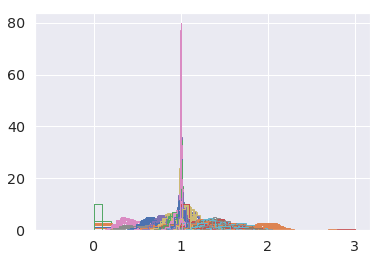

In [175]:
dx0 = 1
m = 10
N = 50
P = 100
delta = []
Ns = np.arange(1,50,5)
for m in tqdm(ms):
    for N in Ns:
        mu = np.random.randn(N)
        mu /= np.linalg.norm(mu)

        s = np.random.randn(m,P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xatrain = mu*dx0/2 + s

        s = np.random.randn(P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xatest = mu*dx0/2 + s

        s = np.random.randn(m,P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xbtrain = -mu*dx0/2 + s

        xaa = cdist(Xatrain.mean(0),Xatest)
        plt.hist(xaa.ravel(), histtype='step', density=True)

        xab = cdist(Xbtrain.mean(0),Xatest)
        plt.hist(xab.ravel(), histtype='step', density=True);
        # plt.hist((xab - xaa).ravel(), histtype='step', density=True)


        s = np.random.randn(m*P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xatrain = mu*dx0/2 + s

        s = np.random.randn(P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xatest = mu*dx0/2 + s

        s = np.random.randn(P,N)
        s /= np.linalg.norm(s,axis=-1,keepdims=True)
        Xbtrain = -mu*dx0/2 + s

        xaaNN = cdist(Xatrain,Xatest).reshape(m,P,P).min(0)
        plt.hist(xaaNN.ravel(), histtype='step', density=True)

        xab = cdist(Xatrain,Xbtrain).reshape(m,P,P).min(0)
        plt.hist(xab.ravel(), histtype='step', density=True);

        # plt.hist((xab - xaa).ravel(), histtype='step', density=True)
        # plt.yscale('log')

        delta.append(np.mean(xaaNN) - np.mean(xaa))

In [176]:
delta = np.stack(delta).reshape(len(ms),len(Ns))

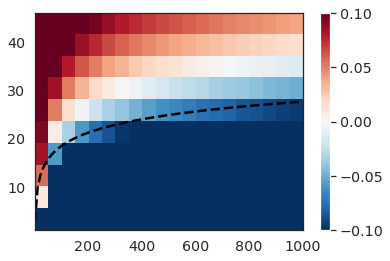

In [183]:
with sns.axes_style('white'):
    plt.imshow(delta.T, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto', vmin=-0.1,vmax=0.1)
plt.colorbar()
xx = np.linspace(np.min(ms),np.max(ms),100)
plt.plot(xx,4*np.log(xx), c='black',linestyle='dashed')

In [149]:
2-np.sqrt(np.log(m)/N)

0.970600430683203

In [16]:
from sklearn.neighbors import KNeighborsClassifier
nn = KNeighborsClassifier(n_neighbors=1)

In [17]:
import numpy as np

In [640]:
P = 100
N = 500
m = 10
dx0 = 1

def sphere_experiment(m,N):
    U = np.random.randn(2*N+1,2*N+1)
#     U,_ = np.linalg.qr(U)
    Ua = U[:N]
    Ub = U[N:2*N]
#     mu = U[-1]

    mu = np.random.randn(N)
    mu /= np.linalg.norm(mu)

    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatrain = mu*dx0/2 + s

    s = np.random.randn(P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatest = mu*dx0/2 + s

    s = np.random.randn(m,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtrain = -mu*dx0/2 + s

    w = Xatrain.mean(0) - Xbtrain.mean(0)
    mu = (Xatrain.mean(0) + Xbtrain.mean(0))/2
    h = Xatest@w - w@mu
    proto_err = (h<0).mean()

    ytrain = np.concatenate([np.ones(m),-np.ones(m)])
    Xtrain = np.vstack([Xatrain,Xbtrain])
    nn.fit(Xtrain,ytrain)
    yhat = nn.predict(Xatest)
    NN_err = (yhat!=1).mean()
    
    return proto_err, NN_err

In [643]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,10)
ms = np.linspace(2,200,20,dtype='int')
n_avg = 19
for m in tqdm(ms):
    for N in Ns:
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

Text(0.5, 1.0, '$\\varepsilon_{NN} - \\varepsilon_{prototype}$')

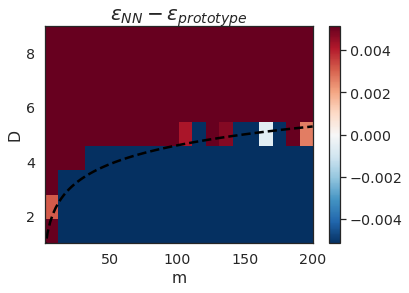

In [644]:
with sns.axes_style('white'):
    diff = -(proto_errs - NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu_r',aspect='auto',vmin=-vmax/100,vmax=vmax/100)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(xx,np.log(xx), c='black',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.title(r'$\varepsilon_{NN} - \varepsilon_{prototype}$',fontsize=20)
# plt.xlim([0,500])
# plt.savefig('images/NN_vs_prototype_theory.pdf')

In [85]:
proto_errs = []
NN_errs = []

Ns = np.arange(1,11)
ms = np.logspace(2,10,10,base=2,dtype='int')
n_avg = 10
for m in tqdm(ms):
    for N in Ns:
        for _ in range(n_avg):
            proto_err, NN_err = sphere_experiment(m,N)
            proto_errs.append(proto_err)
            NN_errs.append(NN_err)
proto_errs = np.stack(proto_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)
NN_errs = np.stack(NN_errs).reshape(len(ms),len(Ns),n_avg).mean(-1)

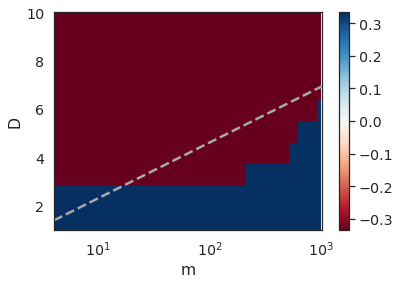

In [90]:
with sns.axes_style('white'):
    diff = np.sign(proto_errs - NN_errs).T
    vmax = np.max(np.abs(diff))
    plt.imshow(diff, origin='lower',
               extent=(np.min(ms),np.max(ms),np.min(Ns),np.max(Ns)),
              cmap='RdBu',aspect='auto',vmin=-vmax/3,vmax=vmax/3)
    
    xx = np.linspace(np.min(ms),np.max(ms),100)
    plt.plot(ms,np.log(ms), c='darkgrey',linestyle='dashed')
    plt.colorbar()
plt.xlabel('m')
plt.ylabel('D');
plt.ylim(np.min(Ns),np.max(Ns))
plt.xscale('log')

In [193]:
np.cos(2)

-0.4161468365471424

In [323]:
sigma = 10
mu = 2
P = 1000
means = []
stds = []
proto_std = []
Ms = []
Xprotos = []
ms = np.arange(1,50)
for m in tqdm(ms):
    X = np.random.randn(m,P) * sigma + 1
    Y = np.random.randn(m,P) * sigma
    M = np.max(X,0) - np.max(Y,0)
    means.append(np.mean(M))
    stds.append(np.std(M))
    Xproto = X.mean(0)
    proto_std.append(np.std(Xproto))
    Ms.append(M)
    Xprotos.append(Xproto)

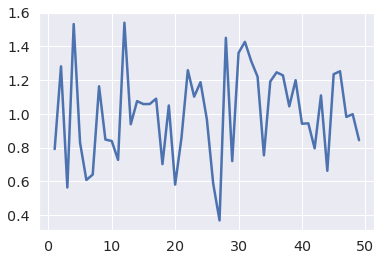

In [325]:
plt.plot(ms,means)
# plt.plot(ms,np.sqrt(np.log(ms)*sigma**2))

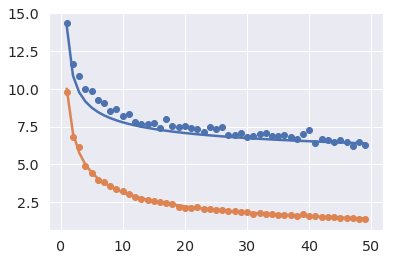

In [326]:
plt.scatter(ms,stds)
plt.plot(ms,sigma/np.sqrt(np.log(ms) + 1)*np.sqrt(2))
plt.scatter(ms,proto_std)
plt.plot(ms,sigma/np.sqrt(ms))

In [1471]:
m = 5
dx0 = 1
P = 1000
N = 50
navg = 2

meanNNa = []
meanNNb = []
stdNNa = []
stdNNb = []
errs = []
proto_errs = []

ms = np.arange(1,40)
mu = np.random.randn(N)
mu /= np.linalg.norm(mu)
for m in tqdm(ms): 
    s = np.random.randn(m,P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatrain = mu*dx0/2 + s

    s = np.random.randn(P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xi = mu*dx0/2 + s

    s = np.random.randn(m,P,N)
    s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xbtrain = -mu*dx0/2 + s

    daNN = ((Xatrain - Xi)**2).sum(-1).min(0)
    dbNN = ((Xbtrain - Xi)**2).sum(-1).min(0)
    
    meanNNa.append(daNN.mean())
    meanNNb.append(dbNN.mean())
    stdNNa.append(daNN.std())
    stdNNb.append(dbNN.std())
    
    # NN errs
    for i in range(navg):
        Xtrain = np.vstack([Xatrain[:,i],Xbtrain[:,i]])
        ytrain = np.concatenate([np.ones(m),-np.ones(m)])
        nn.fit(Xtrain,ytrain)
        err = (nn.predict(Xi)!=1).mean()
        errs.append(err)
        
        # Proto errs
        w = Xatrain[:,i].mean(0) - Xbtrain[:,i].mean(0)
        mutest = (Xatrain[:,i].mean(0) + Xbtrain[:,i].mean(0))/2
        h = Xi@w - w@mutest
        proto_err = (h<0).mean()
        proto_errs.append(proto_err)
errs = np.stack(errs).reshape(len(ms),navg)
proto_errs = np.stack(proto_errs).reshape(len(ms),navg)

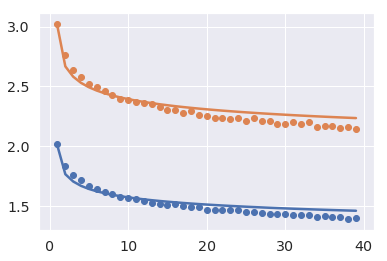

In [1472]:
plt.scatter(ms,meanNNa)
meanahat = 2-2*np.sqrt(np.log(ms)/N)
plt.plot(ms, meanahat)
plt.scatter(ms,meanNNb)
meanbhat = 2+dx0**2-2*np.sqrt(dx0**2+1)*np.sqrt(np.log(ms)/N)
plt.plot(ms, meanbhat)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


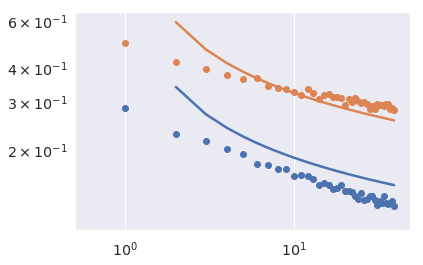

In [1473]:
plt.scatter(ms,stdNNa)
stdahat = 2/(np.sqrt(np.log(ms)*N))
plt.plot(ms, stdahat)
plt.scatter(ms,stdNNb)
stdbhat = 2*np.sqrt(2*dx0**2+1)/(np.sqrt(np.log(ms)*N))
plt.plot(ms, stdbhat)

plt.xscale('log')
plt.yscale('log')

In [1474]:
stdNNa = np.array(stdNNa)
meanNNa = np.array(meanNNa)

stdNNb = np.array(stdNNb)
meanNNb = np.array(meanNNb)

In [1475]:
SNR = (meanNNb - meanNNa)  / np.sqrt(stdNNa**2 + stdNNb**2)
SNRhat = (meanbhat - meanahat) / np.sqrt(stdNNa**2 + stdNNb**2)

In [1476]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

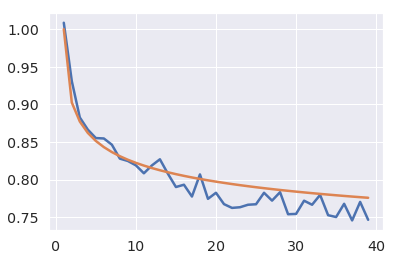

In [1480]:
plt.plot(ms, -meanNNa+meanNNb)
plt.plot(ms, signal)

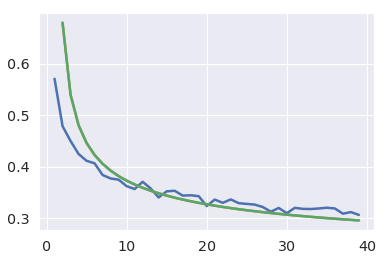

In [1481]:
plt.plot(ms, np.sqrt(stdNNa**2 + stdNNb**2))
plt.plot(ms, noise)
plt.plot(ms, np.sqrt(stdahat**2+stdbhat**2))

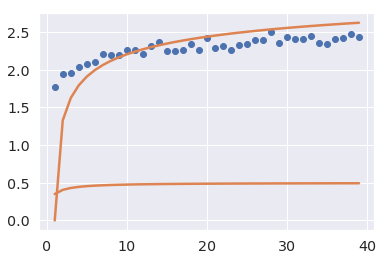

In [1479]:
plt.scatter(ms,SNR)

signal = dx0**2 + 2*(1-np.sqrt(dx0**2+1))*np.sqrt(np.log(ms)/N)
# noise = (1 + 4*np.sqrt(2*dx0**2+1)) / (N*np.log(ms))
noise = np.sqrt(stdahat**2+stdbhat**2)
SNRhat = signal/noise
plt.plot(ms, SNRhat, c='C1')


SNRproto = 1/2*1/np.sqrt(2/(N*ms) + 1 + 1/ms)
plt.plot(ms, SNRproto, c='C1')

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


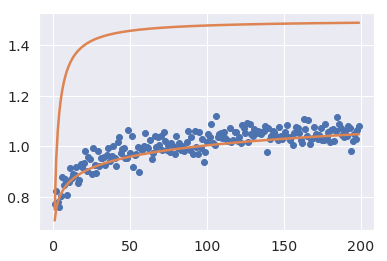

In [967]:
plt.scatter(ms,SNR)

SNRhat = 1/np.sqrt(2)*(1+0.11*(2*np.sqrt(2)-2)*np.sqrt(np.log(ms)/N) / np.sqrt(1/(N*np.log(ms))))
plt.plot(ms, SNRhat, c='C1')


SNRproto = 1/2*1/np.sqrt(2/(N*ms) + 1/N + 1/ms/N)
plt.plot(ms, SNRproto, c='C1')

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


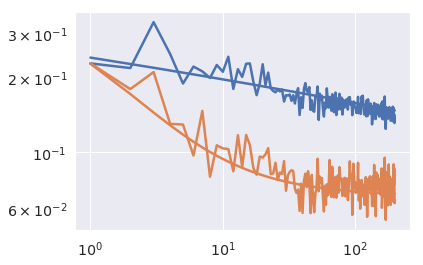

In [975]:
SNRhat = 1/np.sqrt(2)*(1+0.11*(2*np.sqrt(2)-2)*np.sqrt(np.log(ms)/N) / np.sqrt(1/(N*np.log(ms))))
plt.plot(ms, H(SNRhat), c='C0')

SNRproto = 1/2*1/np.sqrt(2/(N*ms) + 1/N + 1/ms/N)
plt.plot(ms, H(SNRproto), c='C1')

plt.plot(ms,errs.mean(-1))
plt.plot(ms,proto_errs.mean(-1))
plt.xscale('log')
plt.yscale('log')

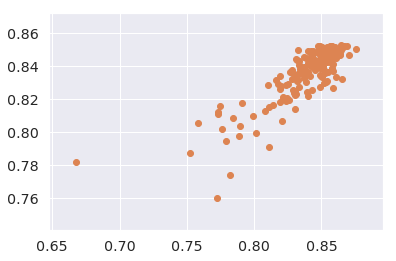

In [972]:
plt.scatter(1-errs.mean(-1),1-H(SNRhat), c='C1')

In [753]:
m = 1
dx0 = 1
P = 1000
D = 100

ms = np.arange(1,500)
mu = np.random.randn(N)
mu /= np.linalg.norm(mu)

s = np.random.randn(m,P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xatrain = mu*dx0/2 + s

s = np.random.randn(P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xi = mu*dx0/2 + s

s = np.random.randn(m,P,N)
s /= np.linalg.norm(s,axis=-1,keepdims=True)
Xbtrain = -mu*dx0/2 + s

daNN = ((Xatrain - Xi)**2).sum(-1).min(0)
dbNN = ((Xbtrain - Xi)**2).sum(-1).min(0)

meanNNa.append(daNN.mean())
meanNNb.append(dbNN.mean())
stdNNa.append(daNN.std())
stdNNb.append(dbNN.std())

In [464]:
da = ((Xatrain-Xatest)**2).sum(-1)
db = ((Xbtrain-Xatest)**2).sum(-1)

In [465]:
np.std(da)

0.20629587550574258

(array([  1.,   3.,  34.,  95., 192., 234., 228., 143.,  52.,  18.]),
 array([0.51362768, 0.65302791, 0.79242813, 0.93182836, 1.07122859,
        1.21062881, 1.35002904, 1.48942927, 1.62882949, 1.76822972,
        1.90762995]),
 <a list of 1 Patch objects>)

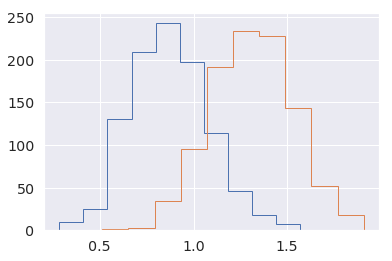

In [470]:
plt.hist(da,histtype='step')
plt.hist(db,histtype='step')

In [468]:
1/np.sqrt(D)

0.1

In [362]:
np.std(db)

1.1375268432948538

In [1349]:
P = 10000
ms = np.arange(1,500,10)
means = []
stds = []
sigmas = [1,5,10]
for sigma in sigmas:
    for m in tqdm(ms):
        X = np.random.randn(m,P) * sigma + 20
        means.append(X.max(0).mean())
        stds.append(X.max(0).std())
stds = np.stack(stds).reshape(len(sigmas),len(ms))

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


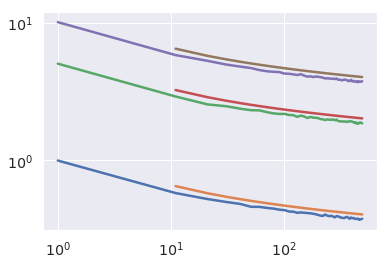

In [1356]:
for sigma, std in zip(sigmas, stds):
    plt.plot(ms,std)
    plt.plot(ms,sigma/np.sqrt(np.log(ms)))
plt.yscale('log')
plt.xscale('log')

In [1386]:
m = 5
dx0 = 2
P = 1000
N = 100
navg = 2

meanNNa = []
meanNNb = []
stdNNa = []
stdNNb = []
errs = []
proto_errs = []

ms = np.arange(1,50,2)
for m in tqdm(ms): 
    s = np.random.randn(m,P,N) / np.sqrt(N)
#     s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xatrain = s

    s = np.random.randn(P,N) / np.sqrt(N)
#     s /= np.linalg.norm(s,axis=-1,keepdims=True)
    Xi = s

    daNN = ((Xatrain - Xi)**2).sum(-1).min(0)
    daNN = (Xatrain*Xi).sum(-1).min(0)
    
    meanNNa.append(daNN.mean())
    stdNNa.append(daNN.std())

In [1387]:
(Xatrain*Xi).sum(-1).shape

(49, 1000)

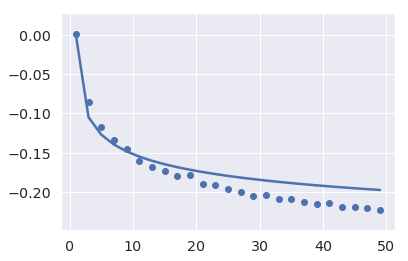

In [1388]:
plt.scatter(ms,meanNNa)
meanahat = -np.sqrt(np.log(ms)/N)
plt.plot(ms, meanahat)

/home/bsorsch/.tf2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


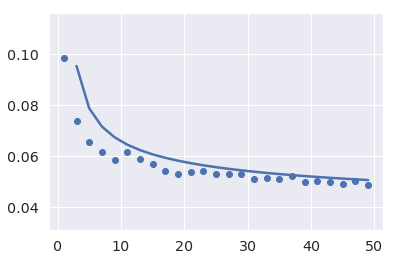

In [1389]:
plt.scatter(ms,stdNNa)
stdahat = 1/(np.sqrt(np.log(ms)*N))
plt.plot(ms, stdahat)

# plt.xscale('log')
# plt.yscale('log')

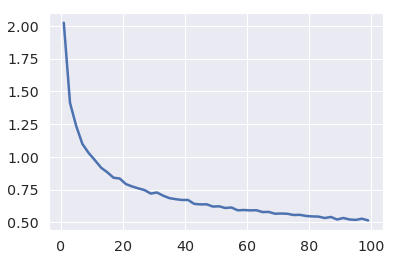

In [1364]:
plt.plot(ms,meanNNa)

In [1482]:
from sklearn.svm import SVC

In [1488]:
svm = SVC(C=1e10,kernel='linear')

In [1521]:
X = np.eye(3)
X[0]*=20
y = np.array([1,1,-1])

svm.fit(X,y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [1522]:
svm.coef_

array([[ 0.0499375 ,  0.99875001, -1.00124688]])

In [1586]:
what = X[:2].mean(0) - X[-1]
bhat = what @ (X.mean(0)) / np.linalg.norm(X.mean(0))   / np.linalg.norm(what)

In [1587]:
w = svm.coef_.squeeze()
b = svm.intercept_
def z(x):
    return (x*w[0] - b) / w[2]

In [1590]:
def z2(x):
    return (x*what[0] + bhat) / what[2]

(-2, 2)

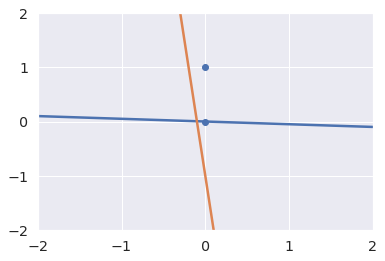

In [1591]:
x = np.linspace(-2,2,100)
plt.plot(x,z(x))
plt.plot(x,z2(x))
plt.scatter(X[:,0],X[:,1])
# plt.axis('equal')
plt.xlim([-2,2,])
plt.ylim([-2,2,])